/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


(<Figure size 800x600 with 1 Axes>, <Axes: >)

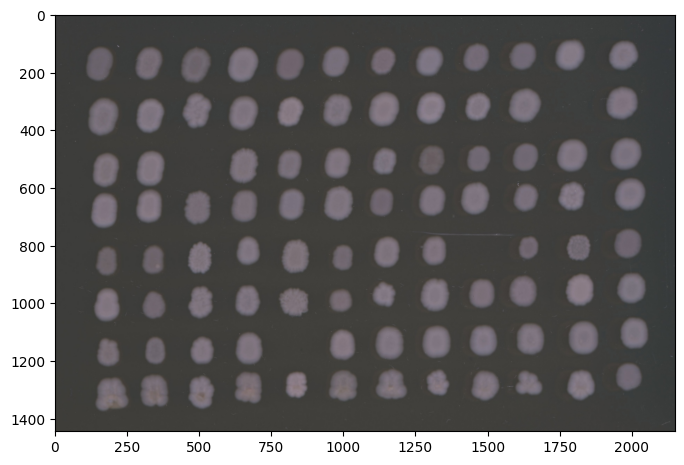

In [1]:
from phenotypic import GridImage, Image

from phenotypic.data import load_plate_72hr

plate_image = GridImage(load_plate_72hr(), name='Plate72Hr')
plate_image.show()

In [2]:
from skimage.color import rgb2gray
print(rgb2gray(load_plate_72hr()).dtype)

float64


/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


In [3]:
from pympler import asizeof

print(f'Array size: {asizeof.asizeof(load_plate_72hr()) / 1000000} mbytes')
print(f'Phenotypic.GridImage: {asizeof.asizeof(plate_image) / 1000000} mbytes')
print(f'Phenotypic.Image: {asizeof.asizeof(Image(load_plate_72hr())) / 1000000} mbytes')

print(f'Ratio: {asizeof.asizeof(plate_image) / asizeof.asizeof(load_plate_72hr())}')

Array size: 9.31396 mbytes
Phenotypic.GridImage: 59.006392 mbytes
Phenotypic.Image: 59.005168 mbytes
Ratio: 6.335255036525817


/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


In [4]:
import os, psutil

proc = psutil.Process(os.getpid())

# RSS: resident set size
rss = proc.memory_info().rss

# Full info gives you USS (unique) on Linux via memory_full_info().uss
full = proc.memory_full_info()
uss = getattr(full, "uss", None)      # Unique Set Size (Linux)
pss = getattr(full, "pss", None)      # Proportional Set Size (Linux)

print(f"RSS = {rss/1024**2:.1f} MB")
if uss is not None:
    print(f"USS = {uss/1024**2:.1f} MB")
if pss is not None:
    print(f"PSS = {pss/1024**2:.1f} MB")

RSS = 537.7 MB
USS = 315.3 MB


In [5]:
total_data_footprint = 0
for data_key, data_value in plate_image._data.__dict__.items():
    print(
        f'{data_key} | {data_value.dtype}: {asizeof.asizeof(data_value) / 1000000} mbytes | shape: {data_value.shape} | fold-increase: {asizeof.asizeof(data_value) / asizeof.asizeof(load_plate_72hr())}')
    total_data_footprint += asizeof.asizeof(data_value)
print(f'Total data footprint: {total_data_footprint / 1000000} mbytes')
print(f'Class overhead: {asizeof.asizeof(plate_image) / 1000000 - total_data_footprint / 1000000}')

array | uint8: 9.31396 mbytes | shape: (1444, 2150, 3) | fold-increase: 1.0
matrix | float64: 24.83696 mbytes | shape: (1444, 2150) | fold-increase: 2.666638035808614
enh_matrix | float64: 24.83696 mbytes | shape: (1444, 2150) | fold-increase: 2.666638035808614
sparse_object_map | uint16: 0.010064 mbytes | shape: (1444, 2150) | fold-increase: 0.0010805285829013653
Total data footprint: 58.997944 mbytes
Class overhead: 0.008368000000004372


/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Projects/PhenoTypic/.venv/lib/python3.12/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


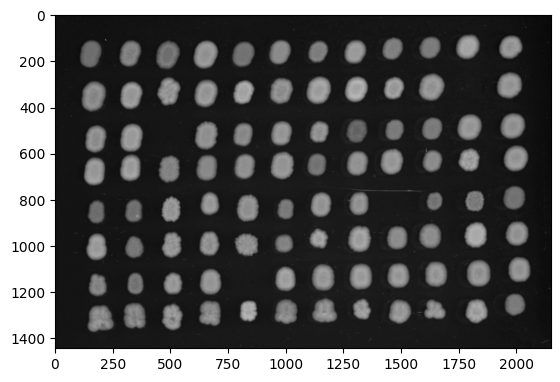

In [6]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
fig, ax = plt.subplots()
ax.grid(False)
ax.imshow(rgb2gray(plate_image.array[:]), cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

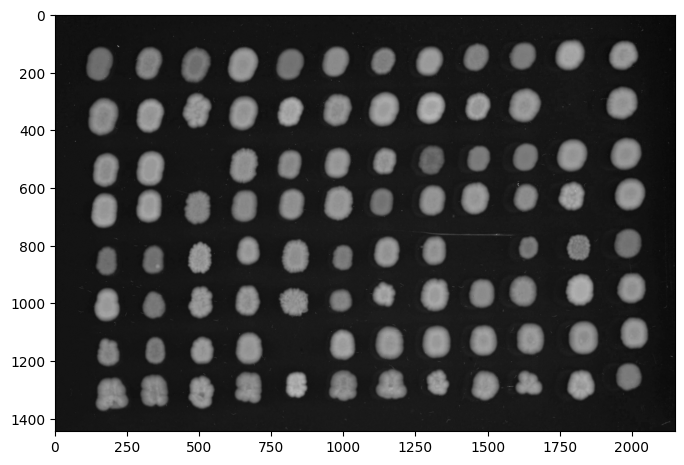

In [7]:
plate_image.matrix.show()

In [8]:
from phenotypic import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import WatershedDetector
from phenotypic.correction import GridAligner, GammaDecoder
from phenotypic.grid import GridApply, MinResidualErrorReducer, GridAlignmentOutlierRemover
from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
from phenotypic.morphology import MaskFill

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    ops={
        'blur': GaussianSmoother(sigma=5),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': WatershedDetector(footprint='auto', min_size=50, relabel=True),
        'mask_fill':MaskFill(),
        'RemoveBorderObjects': BorderObjectRemover(),
        'low circularity remover': LowCircularityRemover(0.7),
        'reduce by section residual error': MinResidualErrorReducer(),
        'outlier removal': GridAlignmentOutlierRemover(),
        'align': GridAligner(),
        'grid_reduction': MinResidualErrorReducer(),
    },
    meas={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture(scale=3),
        'MeasureTexture2': MeasureTexture(scale=4),
    }
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()


KeyboardInterrupt: 

In [9]:
CLAHE.__name__

'CLAHE'

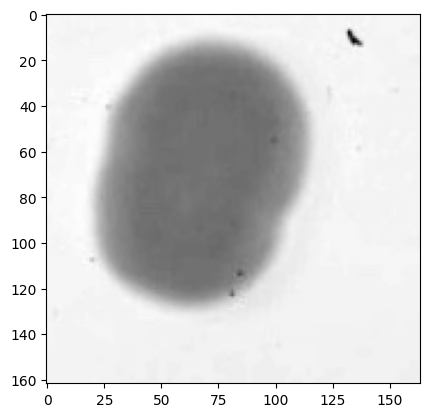

In [10]:
colony_image = pipeline_output.grid[0]
from skimage.util import invert
colony_matrix = invert(colony_image.matrix[:])

import matplotlib.pyplot as plt
plt.imshow(colony_matrix, cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

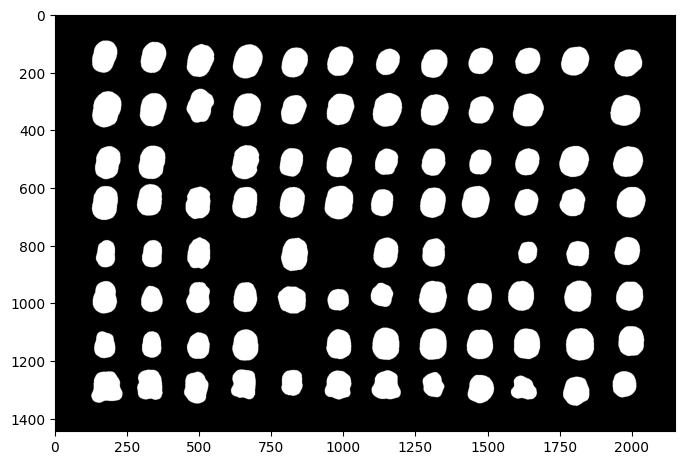

In [11]:
pipeline_output.objmask.show()

In [12]:
# from phenotypic.pipeline import ImagePipelineCore
# from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
# from phenotypic.detection import OtsuDetector
# from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, GridAlignmentOutlierRemover
# from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
#
# from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture
#
# kmarx_pipeline = ImagePipelineCore(
#     ops={
#         'blur': GaussianSmoother(sigma=10),
#         'clahe': CLAHE(),
#         'median filter': MedianEnhancer(),
#         'detection': OtsuDetector(),
#         'border_removal': BorderObjectRemover(50),
#         'low circularity remover': LowCircularityRemover(0.6),
#         'small object remover': SmallObjectRemover(100),
#         'Reduce by section residual error': MinResidualErrorReducer(),
#         'outlier removal': GridAlignmentOutlierRemover(),
#         'align': GridAligner(),
#         'section-level detect': GridApply(ImagePipelineCore({
#             'blur': GaussianSmoother(sigma=5),
#             'median filter': MedianEnhancer(),
#             'contrast stretching': ContrastStretching(),
#             'detection': OtsuDetector(),
#         }
#         )
#         ),
#         'small object remover 2': SmallObjectRemover(100),
#         'grid_reduction': MinResidualErrorReducer()
#     },
#     measurements={
#         'MeasureColor': MeasureColor(),
#         'MeasureShape': MeasureShape(),
#         'MeasureIntensity': MeasureIntensity(),
#         'MeasureTexture': MeasureTexture()}
# )
#
# pipeline_output = kmarx_pipeline.apply(plate_image)
# pipeline_output.show_overlay()
#


In [13]:
pipeline_output.grid.info()

,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_RowInterval,Grid_ColNum,Grid_ColInterval,Grid_SectionIndex,Grid_SectionNum
ObjectLabel,,,,,,,,,,,,,,,
1,GridImage,b'',Plate72Hr,146.389728,171.025220,92,129,204,216,0,"(76, 238)",0,"(103, 267)","(0, 0)",0
2,GridImage,b'',Plate72Hr,149.320484,340.361316,96,297,204,386,0,"(76, 238)",1,"(267, 431)","(0, 1)",1
3,GridImage,b'',Plate72Hr,160.806829,503.310931,104,457,218,552,0,"(76, 238)",2,"(431, 595)","(0, 2)",2
4,GridImage,b'',Plate72Hr,163.592914,667.372290,105,616,223,721,0,"(76, 238)",3,"(595, 759)","(0, 3)",3
5,GridImage,b'',Plate72Hr,162.582913,988.458851,112,944,214,1035,0,"(76, 238)",5,"(923, 1087)","(0, 5)",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,GridImage,b'',Plate72Hr,1293.564356,489.112486,1238,447,1349,532,7,"(1211, 1373)",2,"(431, 595)","(7, 2)",86
87,GridImage,b'',Plate72Hr,1283.914791,1311.578175,1240,1275,1327,1350,7,"(1211, 1373)",7,"(1251, 1415)","(7, 7)",91
88,GridImage,b'',Plate72Hr,1298.131035,1475.668566,1249,1431,1348,1523,7,"(1211, 1373)",8,"(1415, 1579)","(7, 8)",92


In [14]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements

,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_MedianRadius,Shape_MeanRadius,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength,Shape_Compactness,Shape_Orientation
ObjectLabel,,,,,,,,,,,,,,
1,7613.0,335.563492,0.849603,316.517210,14.000000,15.658120,0.697679,24.052405,0.781301,9744.0,116.511637,83.470191,1.177020,-0.295205
2,7445.0,330.149278,0.858329,311.469473,14.000000,15.638814,0.667029,23.902824,0.774553,9612.0,112.947968,84.149837,1.165054,-0.340896
3,8288.0,348.291414,0.858567,328.237068,14.764823,16.526457,0.650268,25.250043,0.765282,10830.0,117.988329,89.636289,1.164732,-0.378287
4,9455.0,369.362482,0.870895,348.749593,16.000000,17.861013,0.605939,27.111143,0.763115,12390.0,123.119680,97.943036,1.148244,-0.405697
5,7327.0,322.492424,0.885313,306.337331,14.000000,15.824517,0.593671,23.918077,0.789377,9282.0,107.748365,86.705934,1.129544,-0.433380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,7272.0,331.320851,0.832465,311.484939,13.601471,15.143153,0.670905,23.346233,0.770747,9435.0,112.079039,83.111471,1.201251,0.022526
87,4976.0,269.036580,0.863908,255.293855,11.401754,12.770168,0.568069,19.491264,0.762605,6525.0,88.076298,72.485089,1.157530,0.207409
88,7021.0,317.078210,0.877558,300.026625,13.892444,15.540999,0.450041,23.401256,0.770861,9108.0,100.315608,89.582614,1.139525,-0.340076


In [15]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements

,Intensity_IntegratedIntensity,Intensity_MinimumIntensity,Intensity_MaximumIntensity,Intensity_MeanIntensity,Intensity_MedianIntensity,Intensity_StandardDeviationIntensity,Intensity_CoefficientVarianceIntensity,Intensity_LowerQuartileIntensity,Intensity_UpperQuartileIntensity,Intensity_InterquartileRangeIntensity
ObjectLabel,,,,,,,,,,
1,2933.874447,0.311414,0.444406,0.385377,0.394091,0.017653,0.045813,0.376276,0.397692,0.021415
2,3082.431938,0.310375,0.449211,0.414027,0.424592,0.028504,0.068856,0.399409,0.434584,0.035175
3,3275.395408,0.321175,0.431167,0.395197,0.398831,0.021245,0.053765,0.385686,0.411761,0.026076
4,4199.409110,0.312269,0.483593,0.444147,0.459015,0.035895,0.080826,0.428050,0.470267,0.042217
5,3103.445762,0.304351,0.457368,0.423563,0.442279,0.033744,0.079678,0.406192,0.448689,0.042497
...,...,...,...,...,...,...,...,...,...,...
86,3202.887343,0.303680,0.499247,0.440441,0.452615,0.036118,0.082016,0.418380,0.469008,0.050628
87,2213.072627,0.301746,0.506686,0.444749,0.458502,0.041264,0.092799,0.421128,0.476198,0.055069
88,3095.907866,0.325562,0.495497,0.440950,0.454311,0.036600,0.083014,0.415938,0.469933,0.053995


In [16]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements

,AngularSecondMomentIntensity-deg(0)-scale(5)),AngularSecondMomentIntensity-deg(45)-scale(5)),AngularSecondMomentIntensity-deg(90)-scale(5)),AngularSecondMomentIntensity-deg(135)-scale(5)),ContrastIntensity-deg(0)-scale(5)),ContrastIntensity-deg(45)-scale(5)),ContrastIntensity-deg(90)-scale(5)),ContrastIntensity-deg(135)-scale(5)),CorrelationIntensity-deg(0)-scale(5)),CorrelationIntensity-deg(45)-scale(5)),...,DifferenceEntropyIntensity-deg(90)-scale(5)),DifferenceEntropyIntensity-deg(135)-scale(5)),InformationCorrelation1Intensity-deg(0)-scale(5)),InformationCorrelation1Intensity-deg(45)-scale(5)),InformationCorrelation1Intensity-deg(90)-scale(5)),InformationCorrelation1Intensity-deg(135)-scale(5)),InformationCorrelation2Intensity-deg(0)-scale(5)),InformationCorrelation2Intensity-deg(45)-scale(5)),InformationCorrelation2Intensity-deg(90)-scale(5)),InformationCorrelation2Intensity-deg(135)-scale(5))
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,0.053166,0.048860,0.056599,0.050400,8.512472,12.454905,7.055316,10.967733,0.707670,0.560213,...,2.273970,2.790713,-0.239618,-0.156261,-0.257964,-0.155517,0.890886,0.797504,0.907007,0.799196
2,0.011008,0.009445,0.011236,0.009924,22.768830,38.862002,17.163429,28.626307,0.713017,0.486741,...,3.099870,3.479363,-0.181421,-0.114054,-0.186633,-0.120412,0.883037,0.779670,0.890006,0.794682
3,0.013533,0.011679,0.015515,0.013180,12.298264,22.137512,10.773210,16.874359,0.736025,0.503566,...,2.866960,3.159251,-0.190023,-0.104726,-0.201190,-0.131999,0.884369,0.750405,0.895638,0.806553
4,0.016269,0.012609,0.017906,0.014564,26.848505,45.803833,25.292044,39.011480,0.787588,0.618952,...,3.143216,3.553185,-0.261009,-0.168454,-0.257143,-0.174104,0.945549,0.871719,0.944159,0.879190
5,0.027632,0.024713,0.028547,0.025721,24.835998,44.826517,24.990396,36.112925,0.778043,0.577116,...,3.007436,3.496957,-0.269429,-0.171475,-0.237508,-0.167286,0.940471,0.859932,0.923318,0.856840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.005044,0.004336,0.005156,0.004236,37.357100,56.033769,32.176110,59.264350,0.718140,0.570939,...,3.530117,4.042268,-0.180310,-0.104568,-0.176567,-0.108920,0.904070,0.790424,0.901650,0.799222
87,0.003916,0.003398,0.003898,0.003280,49.510240,75.829710,46.964573,79.845785,0.708500,0.549302,...,3.804731,4.224031,-0.179541,-0.119938,-0.174906,-0.110888,0.908806,0.828385,0.905172,0.810344
88,0.005614,0.004713,0.005976,0.004879,23.368147,39.458016,22.665092,36.759780,0.834244,0.707495,...,3.305107,3.690273,-0.250509,-0.167278,-0.227815,-0.160053,0.953041,0.891075,0.941541,0.883424


,Color_L*,Color_L*LowerQuartile,Color_L*Mean,Color_L*Median,Color_L*UpperQuartile,Color_L*Maximum,Color_L*StdDev,Color_L*CoefficientVariance,Color_a*,Color_a*LowerQuartile,...,Color_BrightnessMinimum,Color_BrightnessLowerQuartile,Color_BrightnessMean,Color_BrightnessMedian,Color_BrightnessUpperQuartile,Color_BrightnessMaximum,Color_BrightnessStdDev,Color_BrightnessCoefficientVariance,Color_ChromaEstimatedMean,Color_ChromaEstimatedMedian
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,62.627016,67.745690,68.395024,69.047082,69.305304,72.522380,1.318999,0.019288,0.359383,2.859170,...,0.319538,0.399154,0.410361,0.417632,0.425925,0.464044,0.021640,0.052741,3.892572,3.843314
2,62.539531,69.427680,70.409568,71.186971,71.865387,72.840400,2.048784,0.029102,0.388258,2.949231,...,0.321166,0.426260,0.441228,0.454737,0.463474,0.478431,0.031533,0.071475,4.001126,4.289409
3,63.440181,68.437987,69.098298,69.386663,70.299569,71.634485,1.553766,0.022489,0.320337,2.805746,...,0.332307,0.406564,0.418295,0.424850,0.435787,0.458824,0.024099,0.057619,3.547127,3.658586
4,62.698815,71.422908,72.436175,73.482128,74.207375,75.051617,2.491025,0.034393,0.275044,2.884458,...,0.327658,0.458356,0.475579,0.492235,0.503286,0.525370,0.040053,0.084228,4.326897,4.673447
5,62.027989,69.908694,71.050670,72.381064,72.806019,73.374950,2.407463,0.033888,-0.015056,2.869002,...,0.317844,0.433475,0.454867,0.474340,0.482941,0.498006,0.039870,0.087665,4.243613,4.653612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,61.970702,70.759531,72.188565,73.064260,74.126787,76.023562,2.497035,0.034595,0.336957,2.925400,...,0.316838,0.451508,0.472423,0.486981,0.501961,0.533333,0.040174,0.085049,3.906673,4.271715
87,61.804676,70.949140,72.454945,73.448785,74.585051,76.478336,2.846002,0.039288,0.334212,2.889226,...,0.314509,0.451203,0.476879,0.493099,0.511900,0.551030,0.046778,0.098111,4.132379,4.390511
88,63.800141,70.590395,72.221512,73.175413,74.186013,75.792477,2.513012,0.034801,0.491922,2.881842,...,0.343610,0.442768,0.469959,0.485495,0.501961,0.532111,0.040486,0.086161,3.961970,4.196016


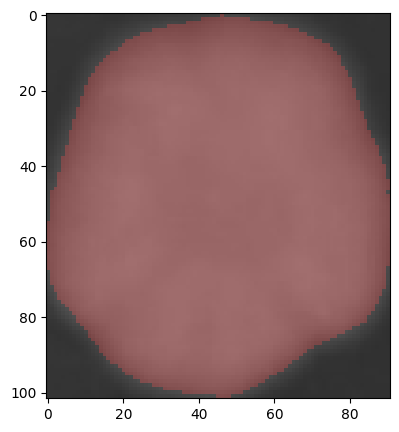

In [17]:
single_object = pipeline_output.objects[-1]
fig, ax = single_object.show_overlay()
color_measurements =MeasureColor().measure(pipeline_output)
color_measurements

In [18]:
color_measurements

,Color_L*,Color_L*LowerQuartile,Color_L*Mean,Color_L*Median,Color_L*UpperQuartile,Color_L*Maximum,Color_L*StdDev,Color_L*CoefficientVariance,Color_a*,Color_a*LowerQuartile,...,Color_BrightnessMinimum,Color_BrightnessLowerQuartile,Color_BrightnessMean,Color_BrightnessMedian,Color_BrightnessUpperQuartile,Color_BrightnessMaximum,Color_BrightnessStdDev,Color_BrightnessCoefficientVariance,Color_ChromaEstimatedMean,Color_ChromaEstimatedMedian
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,62.627016,67.745690,68.395024,69.047082,69.305304,72.522380,1.318999,0.019288,0.359383,2.859170,...,0.319538,0.399154,0.410361,0.417632,0.425925,0.464044,0.021640,0.052741,3.892572,3.843314
2,62.539531,69.427680,70.409568,71.186971,71.865387,72.840400,2.048784,0.029102,0.388258,2.949231,...,0.321166,0.426260,0.441228,0.454737,0.463474,0.478431,0.031533,0.071475,4.001126,4.289409
3,63.440181,68.437987,69.098298,69.386663,70.299569,71.634485,1.553766,0.022489,0.320337,2.805746,...,0.332307,0.406564,0.418295,0.424850,0.435787,0.458824,0.024099,0.057619,3.547127,3.658586
4,62.698815,71.422908,72.436175,73.482128,74.207375,75.051617,2.491025,0.034393,0.275044,2.884458,...,0.327658,0.458356,0.475579,0.492235,0.503286,0.525370,0.040053,0.084228,4.326897,4.673447
5,62.027989,69.908694,71.050670,72.381064,72.806019,73.374950,2.407463,0.033888,-0.015056,2.869002,...,0.317844,0.433475,0.454867,0.474340,0.482941,0.498006,0.039870,0.087665,4.243613,4.653612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,61.970702,70.759531,72.188565,73.064260,74.126787,76.023562,2.497035,0.034595,0.336957,2.925400,...,0.316838,0.451508,0.472423,0.486981,0.501961,0.533333,0.040174,0.085049,3.906673,4.271715
87,61.804676,70.949140,72.454945,73.448785,74.585051,76.478336,2.846002,0.039288,0.334212,2.889226,...,0.314509,0.451203,0.476879,0.493099,0.511900,0.551030,0.046778,0.098111,4.132379,4.390511
88,63.800141,70.590395,72.221512,73.175413,74.186013,75.792477,2.513012,0.034801,0.491922,2.881842,...,0.343610,0.442768,0.469959,0.485495,0.501961,0.532111,0.040486,0.086161,3.961970,4.196016


In [19]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output)

In [20]:
pipeline_measurements

,Metadata_ImageType,Metadata_ParentImageName,Metadata_ImageName,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,...,DifferenceEntropyIntensity-deg(90)-scale(4)),DifferenceEntropyIntensity-deg(135)-scale(4)),InformationCorrelation1Intensity-deg(0)-scale(4)),InformationCorrelation1Intensity-deg(45)-scale(4)),InformationCorrelation1Intensity-deg(90)-scale(4)),InformationCorrelation1Intensity-deg(135)-scale(4)),InformationCorrelation2Intensity-deg(0)-scale(4)),InformationCorrelation2Intensity-deg(45)-scale(4)),InformationCorrelation2Intensity-deg(90)-scale(4)),InformationCorrelation2Intensity-deg(135)-scale(4))
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,GridImage,b'',Plate72Hr,146.389728,171.025220,92,129,204,216,0,...,2.153988,2.630991,-0.282260,-0.194294,-0.296109,-0.198369,0.920386,0.848588,0.929772,0.854970
2,GridImage,b'',Plate72Hr,149.320484,340.361316,96,297,204,386,0,...,2.892390,3.277090,-0.229250,-0.153775,-0.235737,-0.162932,0.924256,0.848860,0.929580,0.862525
3,GridImage,b'',Plate72Hr,160.806829,503.310931,104,457,218,552,0,...,2.652444,2.947733,-0.242220,-0.152738,-0.255330,-0.181143,0.926494,0.839233,0.934571,0.875339
4,GridImage,b'',Plate72Hr,163.592914,667.372290,105,616,223,721,0,...,2.962660,3.356956,-0.307088,-0.214174,-0.302193,-0.219376,0.964416,0.916461,0.963146,0.920944
5,GridImage,b'',Plate72Hr,162.582913,988.458851,112,944,214,1035,0,...,2.841616,3.320149,-0.307027,-0.211007,-0.278132,-0.208404,0.957299,0.901606,0.946291,0.900814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,GridImage,b'',Plate72Hr,1293.564356,489.112486,1238,447,1349,532,7,...,3.304657,3.827585,-0.224511,-0.147989,-0.222629,-0.146923,0.938514,0.867260,0.938179,0.865387
87,GridImage,b'',Plate72Hr,1283.914791,1311.578175,1240,1275,1327,1350,7,...,3.583622,4.020727,-0.222454,-0.159079,-0.217978,-0.149905,0.941739,0.887311,0.939545,0.875588
88,GridImage,b'',Plate72Hr,1298.131035,1475.668566,1249,1431,1348,1523,7,...,3.093299,3.474010,-0.290217,-0.207556,-0.274412,-0.202269,0.968473,0.927799,0.963337,0.924276
